## One Pixel Attack against CIFAR-10 with IHT used for recovery

In [3]:
%load_ext autoreload
%autoreload 2
from __future__ import division
from __future__ import print_function

import sys, os, gc, math
import tensorflow as tf
import numpy as np
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc
from scipy.fftpack import dct,idct



sys.path.append('../')
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

from models.neural_network import NeuralNetwork
from models.cnn import CNN
from models.util import *
from models.one_pixel_attack import *



#Seed used for choosing classes, training points, and test points.
#SEED = 14
SEED=11

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Using TensorFlow backend.


In [4]:
#Define params of model
input_shape = (125,125,3)
num_classes = 10

# Load/Create Network and Adversarial Data

In [5]:
%%capture one
#Load model from disk
model_name = 'cifar10-resnet-big-275'
model_save_path = '../trained_models/' + model_name + '-model.json'
weights_save_path = '../trained_models/' + model_name + 'weights'
model = CNN(model_name=model_name, dataset='cifar10-big', transform='dct-3d',seed=SEED,project=False)
print ('Total Model Params: %d' % model.num_params)
model.load_model(model_save_path, weights_save_path) 
#epochs = 200
#model.train(epochs=epochs)
#model.save_model(model_save_path, weights_save_path)    

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [6]:
%%capture two
#Get training samples
num_train_samples = 1000
data_indices = model.gen_rand_indices(low=int(model.train_data.shape[0]/2), high=model.train_data.shape[0], seed=SEED, num_samples=num_train_samples)
train_data = model.train_data[data_indices]
train_data_labels = model.train_labels[data_indices]
train_data_labels_int = np.argmax(train_data_labels, axis=1)

**GREYBOX ATTACKS**

In [7]:
%%capture three
num_test_samples_per_class = 100
num_test_samples = num_classes*num_test_samples_per_class

#Generate test points
test_indices = model.gen_rand_indices_all_classes(y=model.test_labels, seed=SEED, num_samples=num_test_samples_per_class)

In [10]:
#%%capture four
import time
reg_data = model.test_data[test_indices]
start_time = time.time()
Op = OnePixelAttack(input_shape)
op_data,_ = Op.attack_all(model.model, model.test_data[test_indices], model.test_labels[test_indices])
print("--- OP Time: %s seconds ---" % (time.time() - start_time))

../models/differential_evolution.py:582: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


--- OP Time: 818.755638123 seconds ---


In [12]:
#%%capture five
#np.save('data/reg_data_cifar10-275_op.npy', reg_data)
#np.save('data/op_data_cifar10-275_op.npy', op_data)

In [8]:
reg_data = np.load('data/reg_data_cifar10-275_op.npy')
op_data = np.load('data/op_data_cifar10-275_op.npy')

In [13]:
%%capture six
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='cifar10-big',transform='dct-3d', seed=SEED)
model.load_model(model_save_path, weights_save_path)    

In [9]:
print ('Model Accuracy REG: %.5f' % (model.model.evaluate(reg_data,model.test_labels[test_indices])[1]))
#print ('Model Accuracy CW-l0: %.5f' % (model.model.evaluate(cwl0_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy OP: %.5f' % (model.model.evaluate(op_data,model.test_labels[test_indices])[1]))

1000/1000 [==============================] - 3s 3ms/step
Model Accuracy REG: 0.77400
1000/1000 [==============================] - 1s 1ms/step
Model Accuracy OP: 0.00000


Regular: 


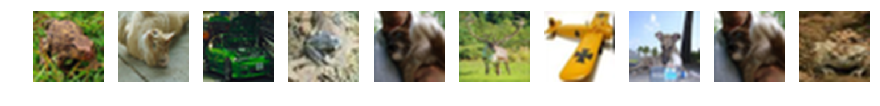

CW-l0: 


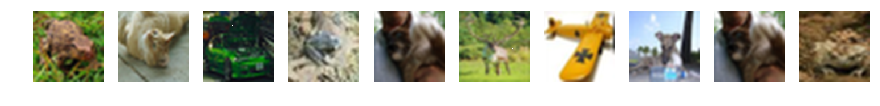

In [14]:
#Lets visualize samples from each attack
x_vis = np.random.choice(range(0,num_test_samples), 10)
print ('Regular: ')
visualize(reg_data[x_vis].reshape(-1,*input_shape), 10, '../figures/reg-cifar10_big-op')
print ('CW-l0: ')
visualize(op_data[x_vis].reshape(-1,*input_shape), 10, '../figures/op-cifar10-big')

In [10]:
%%capture seven
#Get predictions
reg_preds = model.model.predict(reg_data.reshape(-1,*input_shape))
op_preds = model.model.predict(op_data.reshape(-1,*input_shape))

#Convert preds to labels
reg_labels = preds_to_labels(reg_preds)
op_labels = preds_to_labels(op_preds)

#Select Adversarial Points (i.e. points that lead to misclassification)
true_preds = np.argmax(model.test_labels[test_indices], axis=1)

#Check which points are actually adversarial and select those
op_idx = np.where(np.argmax(op_preds, axis=1) != true_preds)[0]


#Filter data points to be used for similarity
op_data_fil = op_data[op_idx]


#Filter labels to be used
op_labels_fil = op_labels[op_idx]

In [11]:
#Get l-0 distortion 
print ('OP-l0: %.5f' % (avg_l0_dist(reg_data[op_idx], op_data_fil)))

OP-l0: 3.00000


# IHT Reconstruction

In [12]:
n=125

In [13]:
clean_op_iht = np.zeros(op_data.shape)
for i in range(num_test_samples):
    x_adv_r = op_data[i,:,:,0].flatten()
    x_adv_g = op_data[i,:,:,1].flatten()
    x_adv_b = op_data[i,:,:,2].flatten()
    
    x_hat_r,_ = iht(x_adv_r,t=1, T=100,k=275)
    x_hat_g,_ = iht(x_adv_g,t=1, T=100,k=275)
    x_hat_b,_ = iht(x_adv_b,t=1, T=100,k=275)
    clean_op_iht[i,:,:,0]= idct(x_hat_r.flatten(),norm='ortho').reshape(n,n)
    clean_op_iht[i,:,:,1]= idct(x_hat_g.flatten(),norm='ortho').reshape(n,n)
    clean_op_iht[i,:,:,2]= idct(x_hat_b.flatten(),norm='ortho').reshape(n,n)

../models/util.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[ind] = x[ind]


In [27]:
clean_reg = np.zeros(op_data.shape)
for i in range(num_test_samples):
    x_adv_r = reg_data[i,:,:,0].flatten()
    x_adv_g = reg_data[i,:,:,1].flatten()
    x_adv_b = reg_data[i,:,:,2].flatten()
    
    x_hat_r = get_top_k(dct(x_adv_r.flatten(),norm='ortho').reshape(n,n),k=275)
    x_hat_g = get_top_k(dct(x_adv_g.flatten(),norm='ortho').reshape(n,n),k=275)
    x_hat_b = get_top_k(dct(x_adv_b.flatten(),norm='ortho').reshape(n,n),k=275)
    clean_reg[i,:,:,0]= idct(x_hat_r.flatten(),norm='ortho').reshape(n,n)
    clean_reg[i,:,:,1]= idct(x_hat_g.flatten(),norm='ortho').reshape(n,n)
    clean_reg[i,:,:,2]= idct(x_hat_b.flatten(),norm='ortho').reshape(n,n)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


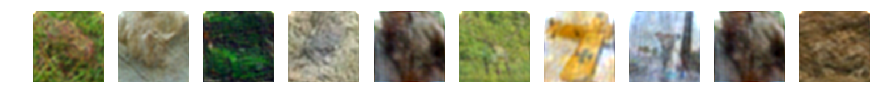

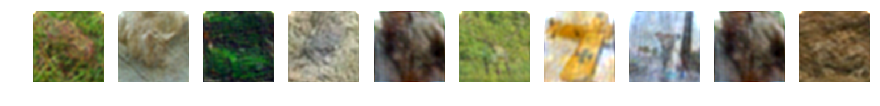

In [28]:
visualize(clean_reg[x_vis].reshape(-1,*input_shape), 10, '../figures/reg-test-cifar10-big_op')
visualize(clean_op_iht[x_vis].reshape(-1,*input_shape), 10, '../figures/op_clean-cifar10-big_op')

In [14]:
print ('Model Accuracy Reconstructed CW-l0: %.5f' % (model.model.evaluate(clean_op_iht,model.test_labels[test_indices])[1]))

1000/1000 [==============================] - 2s 2ms/step
Model Accuracy Reconstructed CW-l0: 0.71800
